In [2]:
%load_ext autoreload
%autoreload 2

In [24]:
import math
import time
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [25]:
import sys
sys.path.append('../src')

In [26]:
from preprocessing import *
from plotting import *
from utils import *

## Reading the database

In [4]:
df_meta = pd.read_csv('../datasets/raw/HT_Sensor_metadata.dat', delimiter='\t+')
df_meta.shape

(100, 5)

In [5]:
df_db = pd.read_csv('../datasets/raw/HT_Sensor_dataset.dat', delimiter='\s+')
df_db.shape

(928991, 12)

## Transforming database in an unique file with all information

In [6]:
df_db.set_index('id', inplace=True)
df_db = df_db.join(df_meta, how='inner')
df_db.set_index(np.arange(df_db.shape[0]), inplace=True)
df_db['time'] += df_db['t0']
# WE DO NOT WANT TO DROP t0 BECASUE IT IS THE MOMENT WHEN STIMULUS STARTS
#df_db.drop(['t0'], axis=1, inplace=True)
df_db.head()

time       R1       R2       R3       R4       R5       R6       R7  \
0  12.490250  12.8621  10.3683  10.4383  11.6699  13.4931  13.3423  8.04169   
1  12.490528  12.8617  10.3682  10.4375  11.6697  13.4927  13.3412  8.04133   
2  12.490806  12.8607  10.3686  10.4370  11.6696  13.4924  13.3405  8.04101   
3  12.491084  12.8602  10.3686  10.4370  11.6697  13.4921  13.3398  8.04086   
4  12.491373  12.8595  10.3688  10.4374  11.6699  13.4919  13.3390  8.04087   

        R8    Temp.  Humidity  id      date   class     t0    dt  
0  8.73901  26.2257   59.0528   0  07-04-15  banana  13.49  1.64  
1  8.73908  26.2308   59.0299   0  07-04-15  banana  13.49  1.64  
2  8.73915  26.2365   59.0093   0  07-04-15  banana  13.49  1.64  
3  8.73936  26.2416   58.9905   0  07-04-15  banana  13.49  1.64  
4  8.73986  26.2462   58.9736   0  07-04-15  banana  13.49  1.64

## Testing how to plot a series

Momento del comienzo del estimulo: 6.49
Momento final del estimulo: 7.21


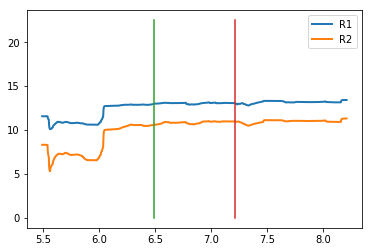

In [54]:
plt.plot(df_db.time[df_db.id==3], df_db.R1[df_db.id==3], linewidth = '2.0')
plt.plot(df_db.time[df_db.id==3], df_db.R2[df_db.id==3], linewidth = '2.0')
#plt.plot(df_db.time[df_db.id==3], df_db.R3[df_db.id==3], linewidth = '2.0')
#plt.plot(df_db.time[df_db.id==3], df_db.R4[df_db.id==3], linewidth = '2.0')
#plt.plot(df_db.time[df_db.id==3], df_db.R5[df_db.id==3], linewidth = '2.0')
#plt.plot(df_db.time[df_db.id==3], df_db.R6[df_db.id==3], linewidth = '2.0')
#plt.plot(df_db.time[df_db.id==3], df_db.R7[df_db.id==3], linewidth = '2.0')
#plt.plot(df_db.time[df_db.id==3], df_db.R8[df_db.id==3], linewidth = '2.0')

stim_start = df_db.t0[df_db.id==3].values[0]
stim_end = df_db.t0[df_db.id==3].values[0] + df_db.dt[df_db.id==3].values[0]
plt.plot([stim_start, stim_start], [0, 22.5])
plt.plot([stim_end, stim_end], [0, 22.5])

plt.legend()
print('Momento del comienzo del estimulo:', df_db.t0[df_db.id==3].values[0])
print('Momento final del estimulo:', df_db.t0[df_db.id==3].values[0]+df_db.dt[df_db.id==3].values[0])

## Testing how to plot all series of all sensors given an ID

Text(0.5, 0.98, 'Sensor Reading on Day 0')

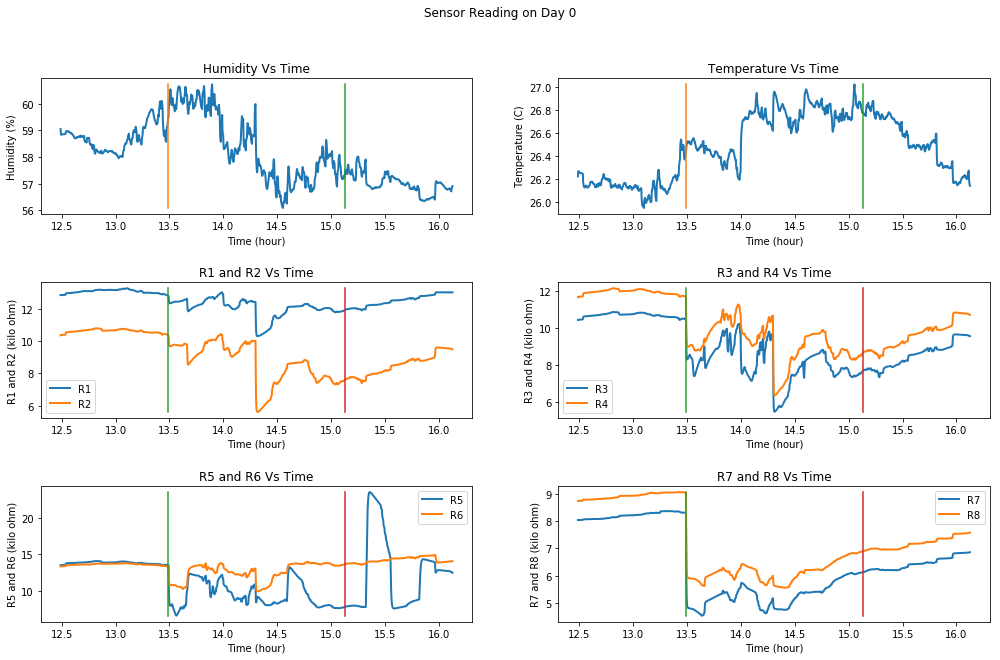

In [84]:
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(17)
fig.subplots_adjust(hspace=.5)

stim_start = df_db.t0[df_db.id==0].values[0]
stim_end = df_db.t0[df_db.id==0].values[0] + df_db.dt[df_db.id==0].values[0]

min_val = min(df_db.Humidity[df_db.id==0])
max_val = max(df_db.Humidity[df_db.id==0])
axes[0,0].plot(df_db.time[df_db.id==0], df_db.Humidity[df_db.id==0], linewidth = '2.0')
axes[0,0].plot([stim_start, stim_start], [min_val, max_val])
axes[0,0].plot([stim_end, stim_end], [min_val, max_val])
axes[0,0].set_title('Humidity Vs Time')
axes[0,0].set_xlabel('Time (hour)')
axes[0,0].set_ylabel('Humidity (%)')

min_val = min(df_db['Temp.'][df_db.id==0])
max_val = max(df_db['Temp.'][df_db.id==0])
axes[0,1].plot(df_db.time[df_db.id==0], df_db['Temp.'][df_db.id==0], linewidth = '2.0')
axes[0,1].plot([stim_start, stim_start], [min_val, max_val])
axes[0,1].plot([stim_end, stim_end], [min_val, max_val])
axes[0,1].set_title('Temperature Vs Time')
axes[0,1].set_xlabel('Time (hour)')
axes[0,1].set_ylabel('Temperature (C)')

min_val1 = min(df_db.R1[df_db.id==0])
min_val2 = min(df_db.R2[df_db.id==0])
min_val = min(min_val1, min_val2)
max_val1 = max(df_db.R1[df_db.id==0])
max_val2 = max(df_db.R2[df_db.id==0])
max_val = max(max_val1, max_val2)
axes[1,0].plot(df_db.time[df_db.id==0], df_db.R1[df_db.id==0], linewidth = '2.0')
axes[1,0].plot(df_db.time[df_db.id==0], df_db.R2[df_db.id==0], linewidth = '2.0')
axes[1,0].plot([stim_start, stim_start], [min_val, max_val])
axes[1,0].plot([stim_end, stim_end], [min_val, max_val])
axes[1,0].set_title('R1 and R2 Vs Time')
axes[1,0].set_xlabel('Time (hour)')
axes[1,0].set_ylabel('R1 and R2 (kilo ohm)')
axes[1,0].legend()

min_val1 = min(df_db.R3[df_db.id==0])
min_val2 = min(df_db.R4[df_db.id==0])
min_val = min(min_val1, min_val2)
max_val1 = max(df_db.R3[df_db.id==0])
max_val2 = max(df_db.R4[df_db.id==0])
max_val = max(max_val1, max_val2)
axes[1,1].plot(df_db.time[df_db.id==0], df_db.R3[df_db.id==0], linewidth = '2.0')
axes[1,1].plot(df_db.time[df_db.id==0], df_db.R4[df_db.id==0], linewidth = '2.0')
axes[1,1].plot([stim_start, stim_start], [min_val, max_val])
axes[1,1].plot([stim_end, stim_end], [min_val, max_val])
axes[1,1].set_title('R3 and R4 Vs Time')
axes[1,1].set_xlabel('Time (hour)')
axes[1,1].set_ylabel('R3 and R4 (kilo ohm)')
axes[1,1].legend()

min_val1 = min(df_db.R5[df_db.id==0])
min_val2 = min(df_db.R6[df_db.id==0])
min_val = min(min_val1, min_val2)
max_val1 = max(df_db.R5[df_db.id==0])
max_val2 = max(df_db.R6[df_db.id==0])
max_val = max(max_val1, max_val2)
axes[2,0].plot(df_db.time[df_db.id==0], df_db.R5[df_db.id==0], linewidth = '2.0')
axes[2,0].plot(df_db.time[df_db.id==0], df_db.R6[df_db.id==0], linewidth = '2.0')
axes[2,0].plot([stim_start, stim_start], [min_val, max_val])
axes[2,0].plot([stim_end, stim_end], [min_val, max_val])
axes[2,0].set_title('R5 and R6 Vs Time')
axes[2,0].set_xlabel('Time (hour)')
axes[2,0].set_ylabel('R5 and R6 (kilo ohm)')
axes[2,0].legend()

min_val1 = min(df_db.R7[df_db.id==0])
min_val2 = min(df_db.R8[df_db.id==0])
min_val = min(min_val1, min_val2)
max_val1 = max(df_db.R7[df_db.id==0])
max_val2 = max(df_db.R8[df_db.id==0])
max_val = max(max_val1, max_val2)
axes[2,1].plot(df_db.time[df_db.id==0], df_db.R7[df_db.id==0], linewidth = '2.0')
axes[2,1].plot(df_db.time[df_db.id==0], df_db.R8[df_db.id==0], linewidth = '2.0')
axes[2,1].plot([stim_start, stim_start], [min_val, max_val])
axes[2,1].plot([stim_end, stim_end], [min_val, max_val])
axes[2,1].set_title('R7 and R8 Vs Time')
axes[2,1].set_xlabel('Time (hour)')
axes[2,1].set_ylabel('R7 and R8 (kilo ohm)')
axes[2,1].legend()

plt.suptitle('Sensor Reading on Day 0')

## Creating a function to avoid repeating code

In [26]:
def plot_series(features_names, id, dataframe, axes, ox, oy, stim_start, stim_end):

    # Calculating minimum value
    min_val = dataframe[features_names[0]][dataframe.id==id].values[0]
    for feat_name in features_names:
        min_val_aux = min(dataframe[feat_name][dataframe.id==id])
        min_val = min(min_val, min_val_aux)

    # Calculating maximum value
    max_val = dataframe[features_names[0]][dataframe.id==id].values[0]
    for feat_name in features_names:
        max_val_aux = max(dataframe[feat_name][dataframe.id==id])
        max_val = max(max_val, max_val_aux)

    # Plotting features
    for feat_name in features_names:
        axes[ox,oy].plot(dataframe.time[dataframe.id==id], dataframe[feat_name][dataframe.id==id], linewidth = '2.0')
    
    # Plotting start and end of stimulus
    axes[ox,oy].plot([stim_start, stim_start], [min_val, max_val])
    axes[ox,oy].plot([stim_end, stim_end], [min_val, max_val])

    ylabel_str = features_names[0]
    for i in range(1, len(features_names)):
        ylabel_str += ' and '+features_names[i]
    
    xlabel_str = 'Time'
    axes[ox,oy].set_title(ylabel_str + ' VS ' + xlabel_str)
    axes[ox,oy].set_xlabel(xlabel_str)
    axes[ox,oy].set_ylabel(ylabel_str)
    axes[ox,oy].legend()



def plot_allSeries_byID(id, dataframe):
    # nrows values is set according to the project
    nrows = 3

    fig, axes = plt.subplots(nrows=nrows, ncols=2)
    fig.set_figheight(10)
    fig.set_figwidth(17)
    fig.subplots_adjust(hspace=.5)

    stim_start = dataframe.t0[dataframe.id==id].values[0]
    stim_end = dataframe.t0[dataframe.id==id].values[0] + dataframe.dt[dataframe.id==id].values[0]

    plot_series(['Humidity'], id, dataframe, axes, 0, 0, stim_start, stim_end)
    plot_series(['Temp.'], id, dataframe, axes, 0, 1, stim_start, stim_end)
    plot_series(['R1', 'R2'], id, dataframe, axes, 1, 0, stim_start, stim_end)
    plot_series(['R3', 'R4'], id, dataframe, axes, 1, 1, stim_start, stim_end)
    plot_series(['R5', 'R6'], id, dataframe, axes, 2, 0, stim_start, stim_end)
    plot_series(['R7', 'R8'], id, dataframe, axes, 2, 1, stim_start, stim_end)

    stim = dataframe['class'][dataframe['id'] == id].values[0]
    plt.suptitle('Sensor Reading on Day '+str(id)+' ('+stim+')')



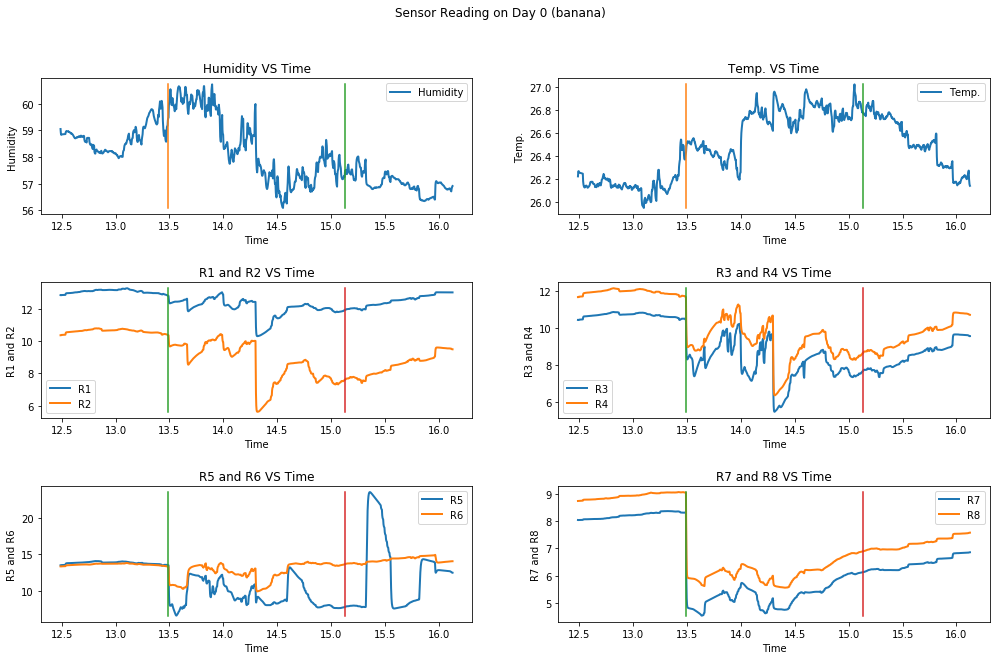

In [27]:
plot_allSeries_byID(0, df_db)

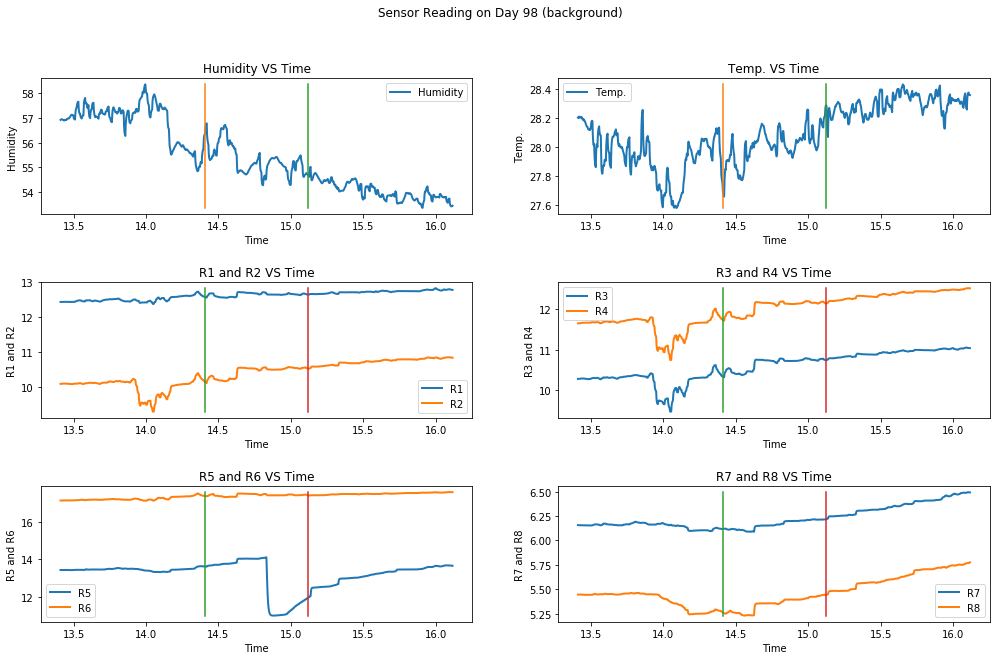

In [35]:
plot_allSeries_byID(98, df_db)

## Plotting a random sample

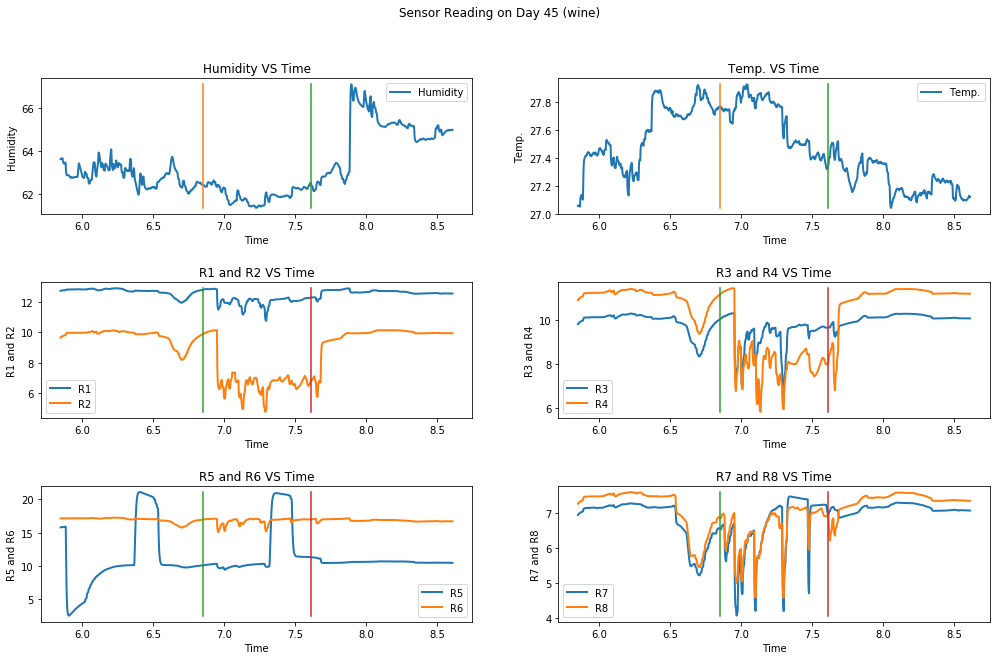

In [33]:
rand_id = 95
while rand_id == 95:
    rand_id = np.random.randint(0, max(df_db.id))
plot_allSeries_byID(rand_id, df_db)

# Plotting probabilities

In [6]:
df_db = group_datafiles_byID('../datasets/preprocessed/HT_Sensor_prep_metadata.dat',
                             '../datasets/preprocessed/HT_Sensor_prep_dataset.dat')
df_db = reclassify_series_samples(df_db)

### Loading best clf at the moment

In [8]:
with open('../models/random_forest_clfs_prep.pkl', 'rb') as f:   
    store_data = pickle.load(f)
store_data[-1]

[35,
 RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=500),
 [2,
  3,
  24,
  29,
  30,
  36,
  49,
  53,
  54,
  59,
  67,
  70,
  74,
  75,
  78,
  80,
  83,
  84,
  87,
  93],
 0.9196168654333741]

In [13]:
best_clf = store_data[-1][1]
print(best_clf)
test_ids = store_data[-1][2]
print(test_ids)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=500)
[2, 3, 24, 29, 30, 36, 49, 53, 54, 59, 67, 70, 74, 75, 78, 80, 83, 84, 87, 93]


In [15]:
df_test = get_df_from_ID_list(df_db, test_ids)
print(df_test.shape)

(191682, 18)


### Metric report of that clf

In [17]:
features = ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'Temp.', 'Humidity']

xtest, ytest = df_test[features].values, df_test['class'].values

In [18]:
y_pred = best_clf.predict(xtest)

TEST SET PROPORTIONS:
	Real background percentage: 0.8178180528166442
	Real banana percentage: 0.044563391450423095
	Real wine percentage: 0.13761855573293266
------------------------------------------
Accuracy: 0.9196168654333741
Recall on background: 0.9825913333035641
Recall on banana: 0.0604073987356591
Recall on wine: 0.8236096895257591
F1-score: 0.9046614728032151


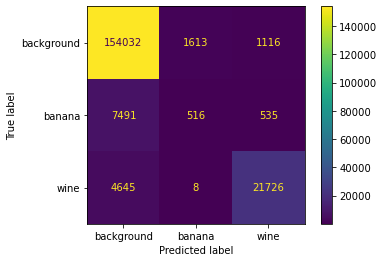

In [19]:
metric_report(ytest, y_pred, plot_conf_mtx=True, clf=best_clf, X=xtest)

In [20]:
probs = best_clf.predict_proba(xtest)

In [23]:
print(probs[0], y_pred[0])
print(probs[100], y_pred[100])
print(probs[55000], y_pred[55000])
print(probs[100000], y_pred[100000])
print(probs[150000], y_pred[150000])

[0.93164681 0.05848409 0.0098691 ] background
[0.93287846 0.05701124 0.01011029] background
[0.03849572 0.00585583 0.95564845] wine
[0.96008148 0.02646374 0.01345478] background
[0.95093317 0.03380201 0.01526483] background


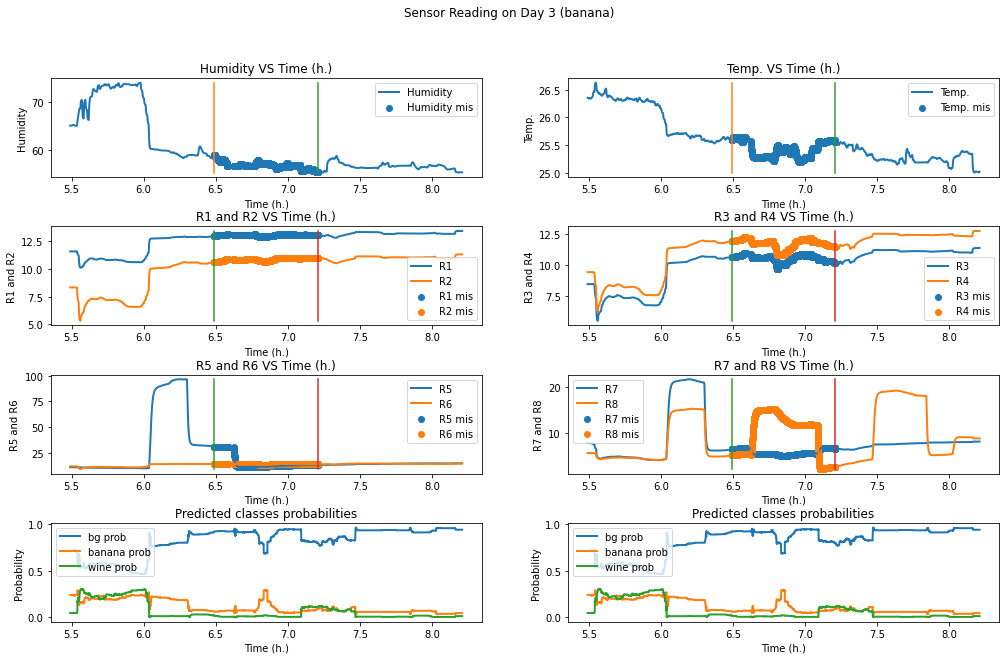

In [46]:
plot_misclassified_byID(df_test, 3, ytest, y_pred, probs_mtx=probs)